#Imports

In [0]:
import pandas as pd

In [0]:
import numpy as np

In [0]:
import seaborn as sns

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

#Load the Dataset

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Dataset
downloaded = drive.CreateFile({'id':"12f9gd7u5hGDwWEZgOd-O9iMkM6lE9vF-"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stock_prices_sample.csv')        # replace the file name with your file

# Prepocessing

In [0]:
df=pd.read_csv('stock_prices_sample.csv', parse_dates=True, index_col='DATE')

In [0]:
df['Year']=df.index.year

In [0]:
# df['Month']=df.index.month

In [0]:
(df['Year']==2013).sum()

3

In [0]:
df.head(10)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO,Year
DATE,,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.2300,47.3700,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0,2013
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.1400,46.4800,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0,2013
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.1600,46.4100,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0,2013
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.8700,18.8700,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0,2018
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0,2018
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468.0,18.580000,18.760000,18.580000,18.740000,17468.0,NaN,0.0,1.0,2018
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,NaN,0.0,1.0,2018
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,NaN,0.0,1.0,2018
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412.0,18.510000,18.510000,18.150000,18.256200,67412.0,NaN,0.0,1.0,2018


In [0]:
df['DateTime'] = pd.to_datetime(df.index)

In [0]:
missing=df.isnull()

In [0]:
df.columns

Index(['TICKER', 'FIGI', 'TYPE', 'FREQUENCY', 'OPEN', 'HIGH', 'LOW', 'CLOSE',
       'VOLUME', 'ADJ_OPEN', 'ADJ_HIGH', 'ADJ_LOW', 'ADJ_CLOSE', 'ADJ_VOLUME',
       'ADJ_FACTOR', 'EX_DIVIDEND', 'SPLIT_RATIO', 'Year', 'DateTime'],
      dtype='object')

In [0]:
df = df[df.TYPE != 'Intraday']

In [0]:
df = df[df.Year != 2013]

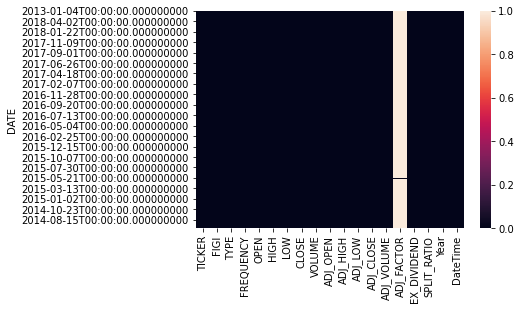

In [0]:
sns.heatmap(missing)

In [0]:
df.drop(['ADJ_FACTOR'], axis=1, inplace=True)

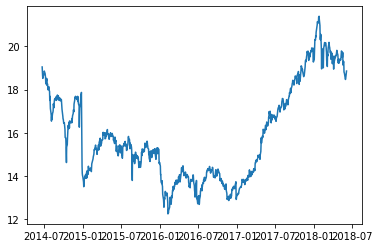

In [0]:
plt.plot(df.index, df['OPEN'])

# Emphasize the growth

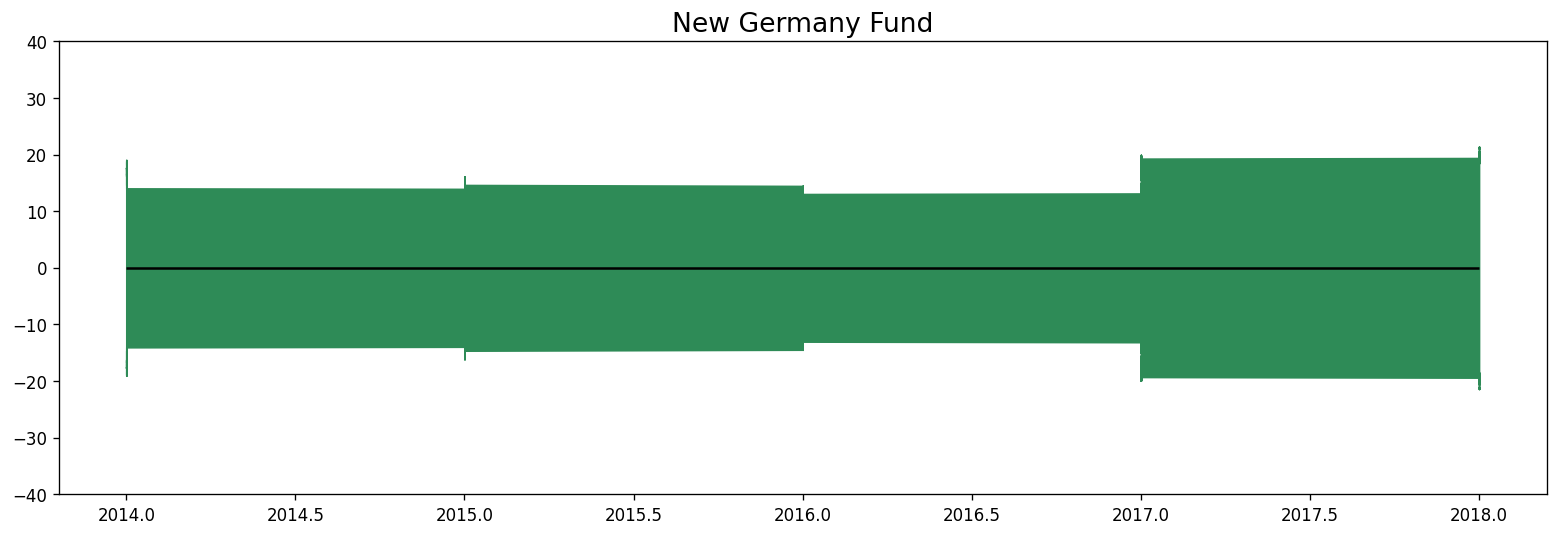

In [0]:
# Import data
# df = pd.read_csv('datasets/AirPassengers.csv', parse_dates=['date'])
x = df['Year'].values
y1 = df['OPEN'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=1,  color='seagreen')
plt.ylim(-40, 40)
plt.title('New Germany Fund', fontsize=16)
plt.hlines(y=0, xmin=np.min(x), xmax=np.max(x))
plt.show()

# AutoCorrelation

In [0]:
from statsmodels.graphics.tsaplots import plot_acf

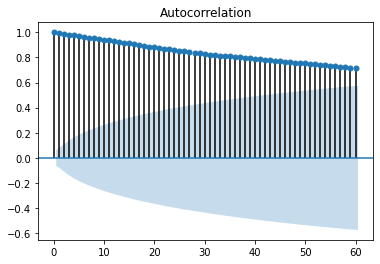

In [0]:
plot_acf(df['y'], lags=30)
plt.show()

# Prophet

Reference: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [0]:
!pip install Prophet

In [0]:
import fbprophet

In [0]:
from fbprophet.diagnostics import cross_validation

# Preprocess for Prophet

In [0]:
# Prophet requires columns ds (Date) and y (value)
df = df.rename(columns={'DateTime': 'ds', 'OPEN': 'y'})

In [0]:
df

,TICKER,FIGI,TYPE,FREQUENCY,y,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,EX_DIVIDEND,SPLIT_RATIO,Year,ds
DATE,,,,,,,,,,,,,,,,,,
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,0.0,1.0,2018,2018-06-04
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468.0,18.580000,18.760000,18.580000,18.740000,17468.0,0.0,1.0,2018,2018-06-01
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,0.0,1.0,2018,2018-05-31
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,0.0,1.0,2018,2018-05-30
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412.0,18.510000,18.510000,18.150000,18.256200,67412.0,0.0,1.0,2018,2018-05-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-27,GF,BBG000C3C6S2,EOD,daily,18.63,18.6300,18.5100,18.6100,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,0.0,1.0,2014,2014-06-27
2014-06-26,GF,BBG000C3C6S2,EOD,daily,18.52,18.5901,18.4200,18.5300,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,0.0,1.0,2014,2014-06-26
2014-06-25,GF,BBG000C3C6S2,EOD,daily,18.66,18.7200,18.5900,18.6000,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,0.0,1.0,2014,2014-06-25


# Fit

In [0]:
df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15, n_changepoints=i)
df_prophet.fit(df)

# Validation

In [0]:
cv_results=cross_validation (df_prophet, "30 days")

INFO:fbprophet:Making 70 forecasts with cutoffs between 2015-07-05 00:00:00 and 2018-05-05 00:00:00


In [0]:
mspe(cv_results.y, cv_results.yhat)

6.075813659522292

# Hyperparameters: Check the Best Value of n_changepoints

In [0]:
MSPE=np.zeros((10,1))

In [0]:
# Make the prophet model and fit on the data
for i in range(10):
  df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15, n_changepoints=i)
  df_prophet.fit(df)
  # future = df_prophet.make_future_dataframe(periods=30, freq='D')
  cv_results=cross_validation (df_prophet, "30 days")
  MSPE[i]=mspe(cv_results.y, cv_results.yhat)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 70 forecasts with cutoffs between 2015-07-05 00:00:00 and 2018-05-05 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 70 forecasts with cutoffs between 2015-07-05 00:00:00 and 2018-05-05 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 70 forecasts with cutoffs between 2015-07-05 00:00:00 and 2018-05-05 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 70 forecasts with cutoffs between 2015-07-05 00:00:00 and 2018-05-05 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 70 forecasts with cutoffs between 2015-07-05 00:00:00 and 2018-05-05

# Plot of MAPE vs n_changepoints

In [0]:
def mape(y_true , y_pred):
  return np.mean(np.abs((np.array(y_true)-np.array(y_pred))/np.array(y_true)))*100 

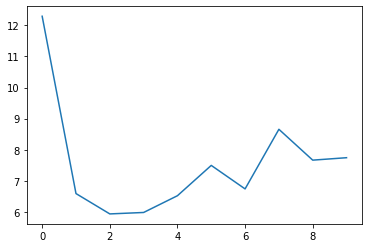

In [0]:
plt.plot(np.arange(0,10,1), MSPE)

# Forecast

In [0]:
future = df_prophet.make_future_dataframe(periods=125, freq='D')
future.tail(10)

,ds
1110,2018-09-28
1111,2018-09-29
1112,2018-09-30
1113,2018-10-01
1114,2018-10-02
1115,2018-10-03
1116,2018-10-04
1117,2018-10-05
1118,2018-10-06
1119,2018-10-07


In [0]:
forecast = df_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1110,2018-09-28,21.404781,20.286210,22.492589
1111,2018-09-29,21.509759,20.442172,22.561356
1112,2018-09-30,21.511617,20.382382,22.579559
1113,2018-10-01,21.410803,20.352877,22.426763
1114,2018-10-02,21.406729,20.314577,22.417558
1115,2018-10-03,21.415508,20.271595,22.379754
1116,2018-10-04,21.404697,20.269485,22.426462
1117,2018-10-05,21.406854,20.266672,22.442975
1118,2018-10-06,21.507326,20.378217,22.519620
1119,2018-10-07,21.506067,20.468116,22.578952


Text(0.5, 1.0, 'NGF')

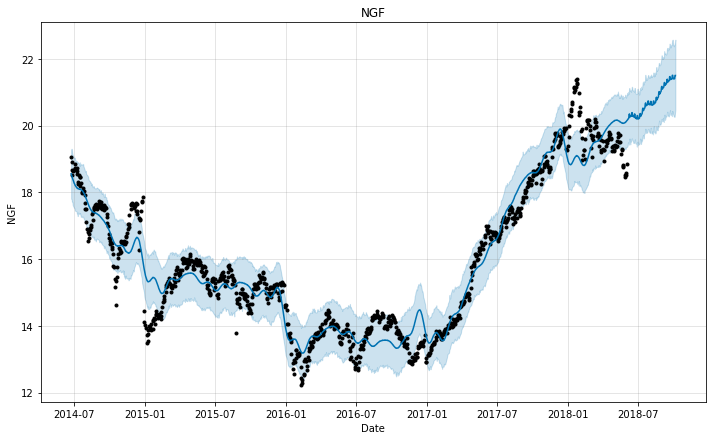

In [0]:
df_prophet.plot(forecast, xlabel = 'Date', ylabel = 'NGF')
plt.title('NGF')